In [2]:
import geopandas as gpd
import ipaddress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
import shapely
import shapely.geometry
import shapely.wkt
import yaml
import time
from tqdm import tqdm
import os
from pathlib import Path

from datetime import date, datetime, timedelta, timezone
from shapely import Point, Polygon, MultiPolygon, GeometryCollection, Geometry
from typing import Tuple, Union

from aimlsse_api.client import GroundDataClient, SatelliteDataClient
from aimlsse_api.data import *

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [3]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [4]:
target_state = 'Montana'

In [5]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir]:
    os.makedirs(dir, exist_ok=True)
server_ip = '141.52.225.23'
# server_ip = '127.0.0.1'

In [6]:
datetime_from = datetime(2022, 8, 1, tzinfo=timezone.utc)
datetime_to = datetime(2023, 2, 1, tzinfo=timezone.utc)
assert datetime_to.date() > datetime_from.date(), f'Dates must be strictly ordered + \
    \nfrom:\t{datetime_from.date()}\nto:\t{datetime_to.date()}'

In [7]:
station_radius_of_influence = 8000.0 # meters

In [8]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

<class 'shapely.geometry.polygon.Polygon'>


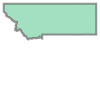

In [9]:
area_of_interest: Union[Polygon, MultiPolygon] = usa_states.loc[target_state].geometry
print(type(area_of_interest))
area_of_interest

In [10]:
def plot_area_of_interest(ax:plt.Axes, color:str):
    gpd.GeoSeries(usa_states.loc[target_state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

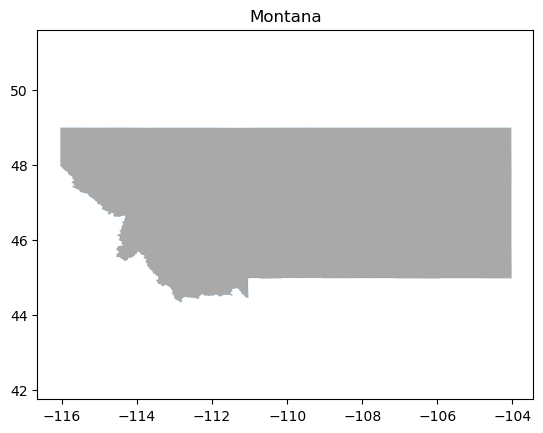

In [11]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
plot_area_of_interest(ax, 'darkgray')

In [12]:
ground_client = GroundDataClient(ipaddress.ip_address(server_ip), 8000)
stations_metadata_filepath = os.path.join(preprocessing_dir, 'station_metadata.csv')
recreate_station_metadata = False
if os.path.exists(stations_metadata_filepath) and not recreate_station_metadata:
    stations_metadata = pd.read_csv(stations_metadata_filepath, index_col=0)
    stations_metadata['geometry'] = stations_metadata['geometry'].apply(shapely.from_wkt)
    stations_metadata = gpd.GeoDataFrame(stations_metadata)
    stations_metadata.set_crs(epsg=4326, inplace=True)
else:
    if isinstance(area_of_interest, Polygon):
        query_polygons = [area_of_interest]
    else:
        query_polygons = list(area_of_interest.geoms)
    stations_metadata = ground_client.queryMetadata(polygons=query_polygons)
    stations_metadata['name'] = stations_metadata['id']
    stations_metadata.set_index('id', inplace=True)
    stations_metadata.to_csv(stations_metadata_filepath)
print(f'Found {len(stations_metadata.index)} stations')

Found 1789 stations


In [13]:
def plot_stations(ax:plt.Axes, color:str):
    stations_metadata.plot(ax=ax, marker='.', color=color, markersize=1)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'Station-coverage of Montana'}>

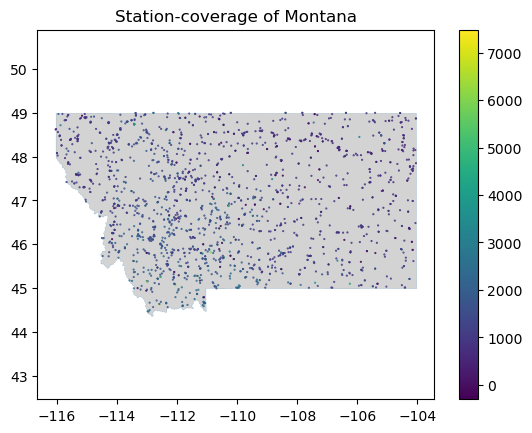

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station-coverage of {target_state}')
plot_area_of_interest(ax, 'lightgray')
stations_metadata.plot('elevation', ax=ax, marker='.', markersize=1, colormap='viridis', legend=True)

In [15]:
satellite_client = SatelliteDataClient(ipaddress.ip_address(server_ip), 8010)
stations_to_sentinel_grid_cells_mapping: gpd.GeoDataFrame = satellite_client.queryContainingGeometry(
    stations_metadata[['name', 'geometry']])
sentinel_grid_cells: gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping.drop_duplicates(subset=['cell_name']).copy()
print(f'Found {len(sentinel_grid_cells.index)} grid-cells')

Found 62 grid-cells


In [16]:
def plot_grid_cells(ax:plt.Axes):
    sentinel_grid_cells['geometry'].buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.5, linewidth=0.8, zorder=2)

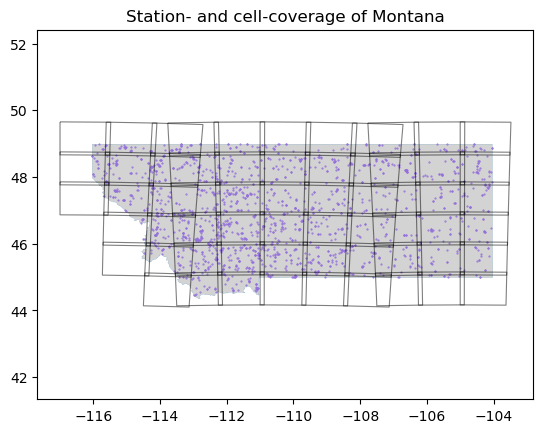

In [17]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station- and cell-coverage of {target_state}')
plot_area_of_interest(ax, 'lightgray')
plot_stations(ax, 'mediumpurple')
plot_grid_cells(ax)

In [18]:
stations_per_grid_cell = stations_to_sentinel_grid_cells_mapping.groupby('cell_name')['name']
print(f'Average number of stations per grid cell: {stations_per_grid_cell.count().mean()}')

Average number of stations per grid cell: 35.725806451612904


In [19]:
sentinel_products_metadata_filepath = os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv')
os.makedirs(os.path.dirname(sentinel_products_metadata_filepath), exist_ok=True)
if os.path.exists(sentinel_products_metadata_filepath):
    sentinel_products_metadata = pd.read_csv(sentinel_products_metadata_filepath, index_col=0)
else:
    sentinel_products_metadata_list = []
    for cell_name in sentinel_grid_cells['cell_name']:
        sentinel_products_metadata_list += [satellite_client.queryProductsMetadata(datetime_from, datetime_to, copernicus_login,
            cell_name=cell_name
        )]
        time.sleep(1)
    sentinel_products_metadata = pd.concat(sentinel_products_metadata_list)
    sentinel_products_metadata.drop_duplicates(inplace=True)
    sentinel_products_metadata.to_csv(sentinel_products_metadata_filepath)
sentinel_products_metadata['footprint'] = sentinel_products_metadata['footprint'].apply(lambda x: shapely.from_wkt(x))
sentinel_products_metadata['geometry'] = sentinel_products_metadata['footprint']
sentinel_products_metadata = gpd.GeoDataFrame(sentinel_products_metadata)
sentinel_products_metadata.set_crs(epsg=4326, inplace=True)
sentinel_products_metadata = sentinel_products_metadata[sentinel_products_metadata['tileid'].isin(sentinel_grid_cells['cell_name'])]
print(f'Found {len(sentinel_products_metadata.index)} entries')

Found 3819 entries


In [20]:
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)

In [21]:
sentinel_products_metadata[date_columns]

,beginposition,endposition,generationdate,ingestiondate
8e37639e-145b-4586-b28b-99eefb8a9c1a,2023-01-31 18:46:19.024000+00:00,2023-01-31 18:46:19.024000+00:00,2023-01-31 20:48:55+00:00,2023-01-31 23:57:56.459000+00:00
a6b1846f-14f0-448a-9598-7fd0a921fbcc,2023-01-26 18:46:41.024000+00:00,2023-01-26 18:46:41.024000+00:00,2023-01-26 20:36:17+00:00,2023-01-26 22:53:07.938000+00:00
cd3986c3-4c65-4238-904c-d8c9f590244e,2023-01-21 18:46:59.024000+00:00,2023-01-21 18:46:59.024000+00:00,2023-01-21 20:38:47+00:00,2023-01-21 23:16:11.014000+00:00
91893b75-2299-4427-9011-45f0a6f7bb6c,2023-01-16 18:47:21.024000+00:00,2023-01-16 18:47:21.024000+00:00,2023-01-16 20:30:20+00:00,2023-01-16 22:16:28.688000+00:00
7811fc9b-0776-4506-bdb6-62a48df33777,2023-01-11 18:47:29.024000+00:00,2023-01-11 18:47:29.024000+00:00,2023-01-11 20:36:42+00:00,2023-01-11 23:06:10.731000+00:00
...,...,...,...,...
0bdf4623-d9e7-471e-a03d-df00f7432f58,2022-08-12 17:59:19.024000+00:00,2022-08-12 17:59:19.024000+00:00,2022-08-12 20:12:30+00:00,2022-08-12 22:11:06.846000+00:00
cae940da-d880-4069-bd65-37cef271e49a,2022-08-09 17:49:09.024000+00:00,2022-08-09 17:49:09.024000+00:00,2022-08-09 21:18:20+00:00,2022-08-09 23:39:12.259000+00:00
0c0e5856-a9b2-4361-bf45-ffd615ec9968,2022-08-07 17:59:21.024000+00:00,2022-08-07 17:59:21.024000+00:00,2022-08-07 21:48:29+00:00,2022-08-08 00:42:55.789000+00:00
8ef997a1-9613-4ec3-8102-f20166ce1107,2022-08-04 17:49:21.024000+00:00,2022-08-04 17:49:21.024000+00:00,2022-08-04 22:49:49+00:00,2022-08-05 03:32:50.534000+00:00


In [22]:
sentinel_products_metadata_per_cell = sentinel_products_metadata.groupby(['tileid'])
sentinel_grid_cells['num_entries'] = sentinel_grid_cells['cell_name'].apply(
    lambda name: len(sentinel_products_metadata_per_cell.get_group(name)) if name in sentinel_products_metadata_per_cell.groups else 0
)

<Axes: ylabel='Frequency'>

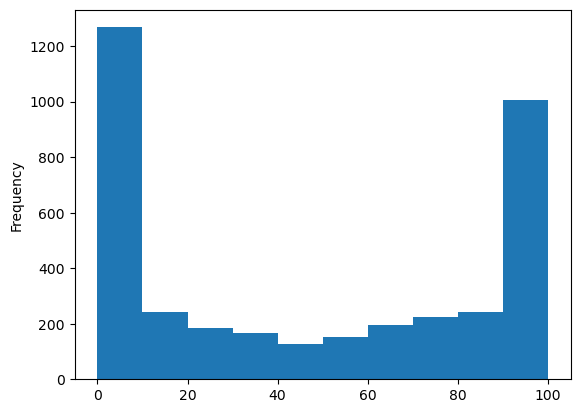

In [23]:
sentinel_products_metadata['cloudcoverpercentage'].plot(kind='hist')

<Axes: title={'center': 'Number of sentinel-products per cell'}>

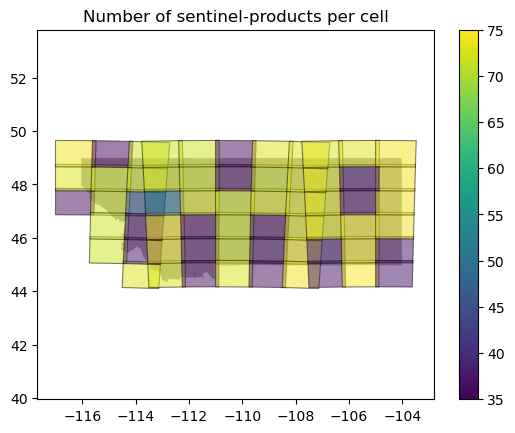

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Number of sentinel-products per cell')
plot_area_of_interest(ax, 'darkgray')
sentinel_grid_cells.plot('num_entries', ax=ax, markersize=0, edgecolor='black', facecolor='red',
    alpha=0.5, linewidth=0.8, legend=True, zorder=2)

In [25]:
products_sorted = sentinel_products_metadata.sort_values(by=['cloudcoverpercentage', 'beginposition'], ascending=[False, True])
products_range_selection = products_sorted[(products_sorted['cloudcoverpercentage'] < 30) | (products_sorted['cloudcoverpercentage'] > 70)].copy()
products_range_selection = products_sorted
print(f'After selection, {len(products_range_selection.index)} of {len(sentinel_products_metadata.index)} products remain')

After selection, 3819 of 3819 products remain


In [26]:
products_range_selection['geometry'] = products_range_selection['footprint']
remaining_grid_cells = products_range_selection.groupby(['tileid'])
print(f'After selection {len(remaining_grid_cells)} of {sentinel_grid_cells.shape[0]} grid cells remain')

After selection 62 of 62 grid cells remain


C:\Users\erikw\AppData\Local\Temp\ipykernel_27332\3631072304.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, data in remaining_grid_cells:


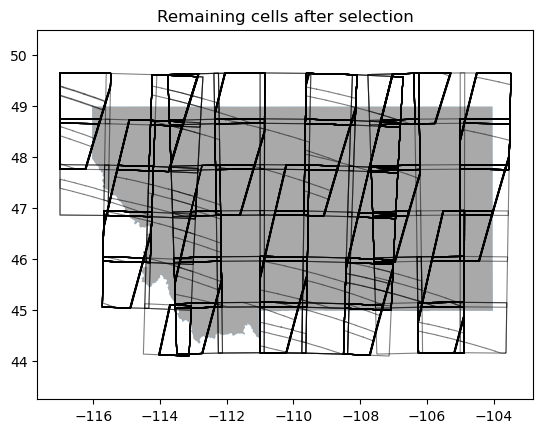

In [27]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Remaining cells after selection')
plot_area_of_interest(ax, 'darkgray')
for label, data in remaining_grid_cells:
    gpd.GeoDataFrame(data.drop_duplicates(subset=['geometry'])).plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.5, linewidth=0.8, zorder=2)

In [28]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [29]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [30]:
products_range_selection['beginposition']

19cd273d-b2b7-4d77-a724-878e4cc5a931   2022-08-24 18:39:19.024000+00:00
8acc3c5d-7fd4-45bf-a73d-0e12cd325145   2022-10-01 18:01:49.024000+00:00
dd503405-a382-40f3-945c-8ffe38e0174a   2022-10-01 18:01:49.024000+00:00
dadc069e-5b5f-4d80-a3e8-4c026066345b   2022-10-01 18:01:49.024000+00:00
e93042c5-500f-4c4a-a6ce-773e49a70af4   2022-10-01 18:01:49.024000+00:00
                                                     ...               
90ba4626-61b9-4fec-9c25-692c213ce937   2023-01-21 17:56:41.024000+00:00
ae88e173-73b6-4c77-adeb-56f210d8484a   2023-01-21 17:56:41.024000+00:00
45bfc1a6-7b52-4d44-afbe-55e8239313ae   2023-01-21 17:56:41.024000+00:00
76a07828-3cb0-4a49-bfe6-cb726c3e1979   2023-01-21 18:46:59.024000+00:00
7697e137-b2ed-48d4-bd56-9d5885230d92   2023-01-30 18:26:11.024000+00:00
Name: beginposition, Length: 3819, dtype: datetime64[ns, UTC]

In [31]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [32]:
cloud_cover_strength = {
    'CLR': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [33]:
properties = [
    MetarProperty(MetarPropertyType.TEMPERATURE, UnitTemperature.CELSIUS),
    MetarProperty(MetarPropertyType.CURRENT_WEATHER),
    MetarProperty(MetarPropertyType.RECENT_WEATHER),
    MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS),
    MetarProperty(MetarPropertyType.METAR_CODE)
]
properties_str = [str(prop) for prop in properties]

relevant_time_window = timedelta(hours=1)

filter_use_radius = True

all_metars_filepath = os.path.join(preprocessing_dir, 'all_metars.json')
recreate_data = False
if os.path.exists(all_metars_filepath):
    all_metars = pd.read_json(all_metars_filepath, orient='table')
    all_metars = MetarPandas.format_dataframe(all_metars, properties)
    if not set(properties_str).issubset(set(all_metars.columns)):
        # Columns are missing - recreate data
        recreate_data = True
else:
    recreate_data = True
if recreate_data:
    print('Recreating data..')
    all_metars_list = []
    for product_id, product in tqdm(products_range_selection.iterrows(), total=products_range_selection.shape[0]):
        # Query METAR data in relevant_time_range (R) like:
        # [obs_datetime - R/2, obs_datetime + R/2]
        half_time_range = relevant_time_window / 2.0
        product_datetime = product['beginposition']
        query_datetime_from = product_datetime - half_time_range
        query_datetime_to = product_datetime + half_time_range
        stations: gpd.GeoDataFrame = stations_metadata.loc[stations_per_grid_cell.get_group(product['tileid'])]
        product_footprint: shapely.MultiPolygon = product['footprint']
        if filter_use_radius:
            stations = stations[stations['geometry'].apply(
                lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
                    .within(product_footprint)
            )]
        else:
            stations = stations[stations.within(product_footprint)]
        if not stations.empty:
            try:
                product_metars = ground_client.queryMetar(query_datetime_from, query_datetime_to, properties, stations['name'].to_list())
            except Exception:
                continue
            product_metars['product_id'] = product_id
            all_metars_list += [product_metars]
    all_metars = pd.concat(all_metars_list)
    all_metars.to_json(all_metars_filepath, orient='table', index=False)
still_all_metars = all_metars
all_metars = all_metars[
    all_metars[str(MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS))].apply(lambda x: len(x) > 0)
]
all_metars = all_metars[all_metars['sky_conditions [M]'].apply(get_max_cloud_cover).isin(cloud_covers_order)]
metars_per_product = all_metars.groupby(['product_id'])

In [34]:
print(all_metars.shape[0])
print(still_all_metars.shape[0])

2698
4519


In [35]:
remaining_stations = all_metars['station'].drop_duplicates()
print(f'{remaining_stations.shape[0]} remaining stations')
remaining_grid_cells_metars:gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping[stations_to_sentinel_grid_cells_mapping['name']
    .isin(remaining_stations)].drop_duplicates(subset=['cell_name'])[['geometry', 'cell_name']].copy()
missing_stations_metadata: gpd.GeoDataFrame = stations_metadata.loc[~stations_metadata.index.isin(remaining_stations)]
missing_stations_metadata = missing_stations_metadata.drop(columns=['index_right'])

32 remaining stations


c:\Users\erikw\anaconda3\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


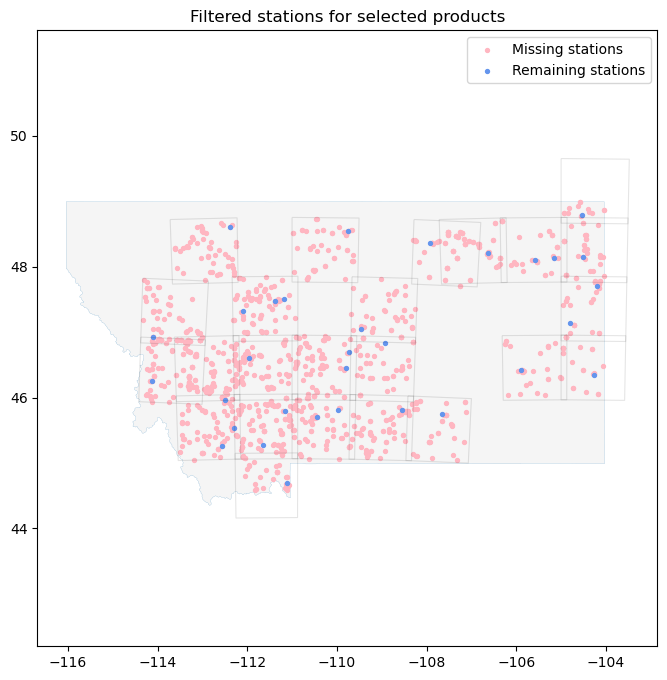

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title('Filtered stations for selected products')
plot_area_of_interest(ax, 'whitesmoke')
remaining_grid_cells_metars.plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.1, linewidth=0.8, zorder=2)
missing_stations_metadata.sjoin(remaining_grid_cells_metars).plot(ax=ax, marker='o', color='lightpink', markersize=8, alpha=1, label='Missing stations')
stations_metadata.loc[remaining_stations].plot(ax=ax, marker='o', color='cornflowerblue', markersize=8, label='Remaining stations')
ax.legend()

In [37]:
products_filtered = sentinel_products_metadata.loc[metars_per_product.groups.keys()]
print('After filtering for the presence of cloud data in METARs and station containment in product footprint,\n'
      f'{len(products_filtered)} of {len(products_range_selection)} products remain '
      f'[{float(len(products_filtered)) / float(len(products_range_selection)) * 100.0:.1f} %]')

After filtering for the presence of cloud data in METARs and station containment in product footprint,
1064 of 3819 products remain [27.9 %]


In [38]:
products_filtered.index

Index(['00327a0f-19d5-4dda-ade2-c8648cfb238b',
       '0095082b-eb0e-4025-aa38-2117c94de5ff',
       '0165b811-52b7-49b2-ab53-e4ce0ebd57db',
       '01757924-724a-4ebf-b869-f05ab014c45c',
       '017fcca6-9f4a-4ddd-8961-fae35904612b',
       '0186890a-de6e-42d3-9b24-987d3add4a9a',
       '01a1394f-357c-417a-b51b-cb87e75c1f40',
       '01df343f-e5fe-4286-bd28-98861375f326',
       '01ff319d-6e4d-4352-b2e4-d0044a755cf1',
       '01ff69b0-01ae-46d0-90e8-a439f7c744eb',
       ...
       'fd9524dd-3c47-4abe-a1a9-65645acaaf47',
       'fdf6977c-debb-4816-b6b3-94d917b36339',
       'febe3d7d-0097-483a-8123-45f5902559ba',
       'fecd9e24-d5b1-4043-ae64-df33ecb1233d',
       'fecfeabd-1077-4bdf-8829-c1c742bae783',
       'fed7ec5b-8e5b-4a2d-9df9-aef0d16dd1b5',
       'ff407f60-3c62-4bf5-a5af-1796396ac98b',
       'ff41d726-1666-4c83-8fd8-82f6217c5173',
       'ff8b19bf-cb9e-4a79-ac2c-ab6e03b2e517',
       'fff87278-9cf2-452f-b630-8d8f5bfa60f1'],
      dtype='object', length=1064)

In [39]:
products_filtered[['beginposition', 'generationdate']].iloc[0]

beginposition    2023-01-02 18:17:49.024000+00:00
generationdate          2023-01-02 19:52:42+00:00
Name: 00327a0f-19d5-4dda-ade2-c8648cfb238b, dtype: datetime64[ns, UTC]

In [40]:
pd.set_option('display.max_colwidth', None)
metars_per_product.get_group(products_filtered.index[0])[['station', 'datetime', 'sky_conditions [M]', 'product_id']]

,station,datetime,sky_conditions [M],product_id
3281,GGW,2023-01-02 18:47:00,"[DataSkyConditions(cover='OVC', height=60.9599980493, cloud=None)]",00327a0f-19d5-4dda-ade2-c8648cfb238b


<Axes: >

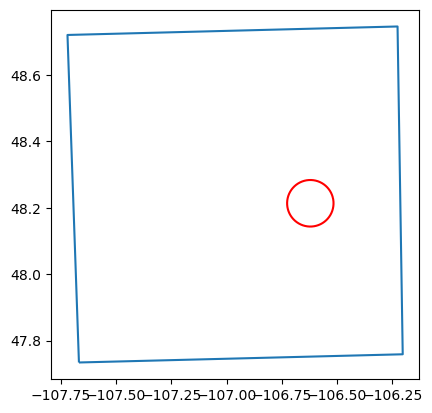

In [41]:
fig, ax = plt.subplots()
product_id_to_plot = products_filtered.index[0]
gpd.GeoDataFrame(pd.DataFrame(sentinel_products_metadata.loc[product_id_to_plot]).T).boundary.plot(ax=ax)
stations_metadata.loc[metars_per_product.get_group(product_id_to_plot)['station']]['geometry'].apply(
    lambda x: sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).boundary
).plot(ax=ax, color='red')

In [42]:
run_cleanup = True

if run_cleanup:
    product_files_local = pd.Series(os.listdir(features_dir))
    products_local = product_files_local.apply(lambda x: Path(x).stem)
    products_to_clean = products_local[~products_local.isin(products_filtered.index)]
    products_to_clean_percentage = 0.0
    if products_local.shape[0] != 0:
        products_to_clean_percentage = products_to_clean.shape[0] / products_local.shape[0] * 100.0
    print(f'{products_to_clean.shape[0]} of {products_local.shape[0]} products are not needed and will be removed'
          f' [{products_to_clean_percentage:.1f} %]')
    for product in products_to_clean:
        for file in product_files_local[product_files_local.str.startswith(product)]:
            os.remove(os.path.join(features_dir, file))

0 of 300 products are not needed and will be removed [0.0 %]


In [44]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

os.makedirs(features_dir, exist_ok=True)
if 'state' not in products_filtered.columns:
    products_filtered['state'] = QueryStates.NEW
available_product_ids = [Path(file).stem for file in os.listdir(features_dir)]
products_filtered.loc[available_product_ids, 'state'] = QueryStates.AVAILABLE
products_to_download = products_filtered[~products_filtered['state'].isin(
    [QueryStates.AVAILABLE, QueryStates.INVALID, QueryStates.PROCESSED, QueryStates.UNAVAILABLE]
)]
print(f'{products_to_download.shape[0]} of {products_filtered.shape[0]} products are missing'
      f' [{products_to_download.shape[0] / products_filtered.shape[0] * 100.0:.1f} %]')
num_products_ignore = products_filtered.shape[0] - products_to_download.shape[0]
for product_id in tqdm(products_to_download.index, initial=num_products_ignore, total= products_filtered.shape[0]):
    if any(filter(lambda path: path == product_id, available_product_ids)):
        # Skip existing files and directories
        continue
    if product_id not in metars_per_product.groups.keys():
        # If no data is available for a tile, skip it
        continue

    product_state = satellite_client.requestProduct(product_id, copernicus_login)
    products_filtered.at[product_id, 'state'] = product_state
    if product_state != QueryStates.AVAILABLE:
        continue

    stations: pd.Series = metars_per_product.get_group(product_id)['station']
    stations = stations.drop_duplicates()
    stations_with_geometry = stations_metadata[stations_metadata['name'].isin(stations)].copy()
    stations_with_geometry['name'] = stations_with_geometry.index
    stations_with_geometry = stations_with_geometry[['name', 'geometry']]
    stations_gdf = gpd.GeoDataFrame(stations_with_geometry)
    stations_gdf.set_crs(crs='EPSG:4326', inplace=True)
    satellite_client.extractFeatures(product_id, station_radius_of_influence, bands, stations_gdf, features_dir)
    time.sleep(1)

565 of 1064 products are missing [53.1 %]


100%|██████████| 1064/1064 [3:05:09<00:00, 19.66s/it] 


In [45]:
products_filtered.groupby(['state'])['state'].count()

state
QueryStates.AVAILABLE      715
QueryStates.NEW              2
QueryStates.PENDING        145
QueryStates.UNAVAILABLE    202
Name: state, dtype: int64

In [46]:
available_products = products_filtered[products_filtered['state'] == QueryStates.AVAILABLE]
print(f'{available_products.shape[0]} of {products_filtered.shape[0]} products are available [\
{float(available_products.shape[0]) / float(products_filtered.shape[0]) * 100.0:.1f} %]')

715 of 1064 products are available [67.2 %]


In [47]:
available_products['beginposition']

00327a0f-19d5-4dda-ade2-c8648cfb238b   2023-01-02 18:17:49.024000+00:00
0095082b-eb0e-4025-aa38-2117c94de5ff   2022-10-12 18:23:11.024000+00:00
0165b811-52b7-49b2-ab53-e4ce0ebd57db   2023-01-07 18:17:31.024000+00:00
01757924-724a-4ebf-b869-f05ab014c45c   2022-10-12 18:23:11.024000+00:00
017fcca6-9f4a-4ddd-8961-fae35904612b   2022-12-30 18:07:49.024000+00:00
                                                     ...               
fed7ec5b-8e5b-4a2d-9df9-aef0d16dd1b5   2023-01-29 18:06:09.024000+00:00
ff407f60-3c62-4bf5-a5af-1796396ac98b   2022-12-09 18:37:49.024000+00:00
ff41d726-1666-4c83-8fd8-82f6217c5173   2022-12-09 18:37:49.024000+00:00
ff8b19bf-cb9e-4a79-ac2c-ab6e03b2e517   2023-01-26 17:56:19.024000+00:00
fff87278-9cf2-452f-b630-8d8f5bfa60f1   2022-12-19 18:37:59.024000+00:00
Name: beginposition, Length: 715, dtype: datetime64[ns, UTC]